### This notebook is to perform random forest classification on Ratio_Activation

In [1]:
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [2]:
taxa = pd.read_csv('../data/57316_deblur_taxonomy/taxonomy.tsv', sep='\t', index_col='Feature ID')

In [3]:
taxa.head()

Taxon  \
Feature ID                                                                                              
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   

                                                    Confidence  
Feature ID                                                      
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...    1.000000  
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...    1.000000  
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...    1.000000  
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...    0.999998  
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...    0.999991

In [4]:
mf = pd.read_csv('../data/mros_mapping_alpha.txt', sep='\t', index_col='#SampleID')

In [5]:
mf.head()

BarcodeSequence  LinkerPrimerSequence  \
#SampleID                                         
BI0023       TCTGGTGACATT  GGACTACHVGGGTWTCTAAT   
BI0056       CAAGCATGCCTA  GGACTACHVGGGTWTCTAAT   
BI0131       CTATTTGCGACA  GGACTACHVGGGTWTCTAAT   
BI0153       ATCGGCGTTACA  GGACTACHVGGGTWTCTAAT   
BI0215       CCTCTCGTGATC  GGACTACHVGGGTWTCTAAT   

                               Experiment_Design_Description  \
#SampleID                                                      
BI0023     16S stool samples sequenced for MrOS Vitamin D...   
BI0056     16S stool samples sequenced for MrOS Vitamin D...   
BI0131     16S stool samples sequenced for MrOS Vitamin D...   
BI0153     16S stool samples sequenced for MrOS Vitamin D...   
BI0215     16S stool samples sequenced for MrOS Vitamin D...   

          Library_Construction_Protocol Linker  Platform Center_Name  \
#SampleID                                                              
BI0023                      16S rRNA v4     GT  Illumina          BI   
BI0056                      16S rRNA v4     GT  Illumina          BI   
BI0131                      16S rRNA v4     GT  Illumina          BI   
BI0153                      16S rRNA v4     GT  Illumina          BI   
BI0215                      16S rRNA v4     GT  Illumina          BI   

          Center_Project Instrument_Model          Title  ...  \
#SampleID                                                 ...   
BI0023              MrOS   Illumina MiSeq  MrOS_VitaminD  ...   
BI0056              MrOS   Illumina MiSeq  MrOS_VitaminD  ...   
BI0131              MrOS   Illumina MiSeq  MrOS_VitaminD  ...   
BI0153              MrOS   Illumina MiSeq  MrOS_VitaminD  ...   
BI0215              MrOS   Illumina MiSeq  MrOS_VitaminD  ...   

          ratio_catabolism            QLCOMP M1STATIN Antihistamine Laxative  \
#SampleID                                                                      
BI0023            0.068605  1:GOOD/EXCELLENT    0: No          0:No     0:No   
BI0056            0.099745  1:GOOD/EXCELLENT    0: No          0:No     0:No   
BI0131            0.064502  1:GOOD/EXCELLENT   1: Yes          0:No     0:No   
BI0153            0.078388  1:GOOD/EXCELLENT   1: Yes          0:No     0:No   
BI0215            0.109697  1:GOOD/EXCELLENT    0: No          0:No     0:No   

           MIDATA Rstarch_total Rstarches_c M1PPUMP   alpha_pd  
#SampleID                                                       
BI0023     1: Yes      3.066569         0.0   0: No  30.021398  
BI0056     1: Yes      3.038136         0.0  1: Yes  18.414977  
BI0131     1: Yes      2.840599         0.0   0: No  25.756952  
BI0153     1: Yes      4.106798         0.0   0: No  20.167914  
BI0215     1: Yes      0.971114         0.0   0: No  20.714331  

[5 rows x 75 columns]

In [6]:
# create extreme categories on Vitamin D measurements
mf = mf[['OHV1D3', 'OHV24D3', 'OHVD3', 'ratio_activation', 'ratio_catabolism', 'VDstatus']]
mf.shape

(598, 6)

In [7]:
mf.describe()

OHV1D3     OHV24D3       OHVD3  ratio_activation  ratio_catabolism
count  566.000000  566.000000  555.000000        555.000000        555.000000
mean     0.057802    3.431343   35.224865          0.001774          0.094795
std      0.019780    1.836358   12.461583          0.000735          0.029794
min      0.010700    0.300000    7.800000          0.000398          0.018788
25%      0.044125    2.167500   27.400000          0.001319          0.074162
50%      0.055500    3.185000   33.600000          0.001661          0.092838
75%      0.066350    4.237500   41.850000          0.002081          0.113049
max      0.156000   14.070000  104.000000          0.006727          0.197786

/Users/ssun/miniconda3/envs/python3-new/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


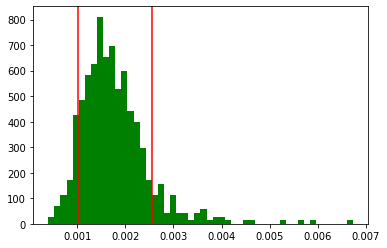

In [8]:
n, bins, patches = plt.hist(mf.ratio_activation.dropna(), 50, normed=1, facecolor='green')
plt.axvline(x=mf['ratio_activation'].quantile([0.10]).values, color='r')
plt.axvline(x=mf['ratio_activation'].quantile([0.90]).values, color='r')

In [9]:
q1 = mf['ratio_activation'].quantile([0.10]).values
q3 = mf['ratio_activation'].quantile([0.90]).values
def act_extreme(x):
    if (x <= q1):
        return(0)
    elif (x >= q3):
        return(1)
    else:
        return('NaN')
mf['Ract_cat'] = mf['ratio_activation'].apply(act_extreme)

In [10]:
mf['Ract_cat'].value_counts()

NaN    486
1       56
0       56
Name: Ract_cat, dtype: int64

In [11]:
table = pd.read_csv('../data/57316_mros_otus_rare_exp/57316_feature-table-rare.txt', sep='\t', skiprows = 1, index_col = "#OTU ID").transpose()

In [12]:
table.shape

(598, 25292)

In [13]:
## match metadata and OTU table by sampleID
sample_ids = mf.index
sample_ids

Index(['BI0023', 'BI0056', 'BI0131', 'BI0153', 'BI0215', 'BI0353', 'BI0371',
       'BI0372', 'BI0380', 'BI0389',
       ...
       'SD8954', 'SD8964', 'SD8966', 'SD8972', 'SD8973', 'SD8985', 'SD8996',
       'SD8999', 'SD9003', 'SD9009'],
      dtype='object', name='#SampleID', length=598)

In [14]:
table = table.loc[sample_ids] # order rows in same order as matrix's rows (sampleIDs)

In [15]:
table.head()

#OTU ID    TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG  \
#SampleID                                                                                                                                                           
BI0023                                                   3.0                                                                                                        
BI0056                                                   1.0                                                                                                        
BI0131                                                   0.0                                                                                                        
BI0153                                                   1.0                                                                                                        
BI0215                                                   0.0                                                                                                        

#OTU ID    TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAACATCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG  \
#SampleID                                                                                                                                                           
BI0023                                                   0.0                                                                                                        
BI0056                                                   0.0                                                                                                        
BI0131                                                   0.0                                                                                                        
BI0153                                                   1.0                                                                                                        
BI0215                                                   0.0                                                                                                        

#OTU ID    TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGCGGCGTAAGTCAGTTGTGAAATCGTGCGGCTTAACCGTGCAATTGCAGTTGATACTGCGTCGCTTGAGTGCACACAGGGATGTTGGAATTCATGG  \
#SampleID                                                                                                                                                           
BI0023                                                   0.0                                                                                                        
BI0056                                                   0.0                                                                                                        
BI0131                                                   0.0                                                                                                        
BI0153                                                   0.0                                                                                                        
BI0215                                                   0.0                                                                                                        

#OTU ID    TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGAGGCTCAACCTCTGCACTGCAGCGCGAACTGGTCTTCTTGAGTACGCACAACGTGGGCGGAATTCGTGG  \
#SampleID                                                                                                                                                           
BI0023                                                   0.0                                                                                                        
BI0056                               

## random forest classification 

### ratio activation

In [16]:
# filter away samples with NaN values
Y = mf[mf.Ract_cat != 'NaN']
Y.shape

(112, 7)

In [17]:
X = table.loc[Y.index]
X.shape

(112, 25292)

In [18]:
# convert to numpy array
# X - rarefied OTU table; Y - vitamin D categories
y = pd.factorize(Y['Ract_cat'])[0] # to get dtype 'int' instead of 'O'
X = X.as_matrix()

/Users/ssun/miniconda3/envs/python3-new/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [19]:
m = np.logspace(2, 8, num=9, base=2, dtype=int)
param_grid = {"max_features": m,
              "min_samples_split": [2, 3, 7],
              "min_samples_leaf": [1, 3, 7],
              "bootstrap": [True, False]}
ParameterGrid(param_grid)[1]

{'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 4,
 'bootstrap': True}

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


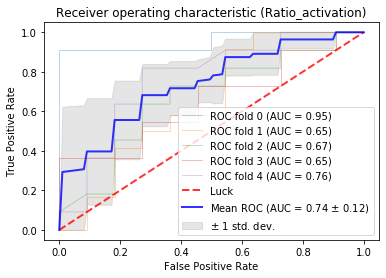

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}


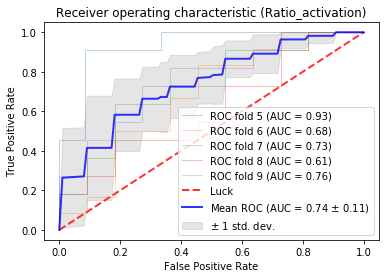

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 7}


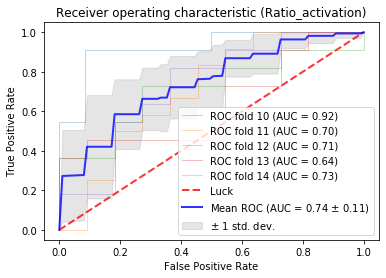

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


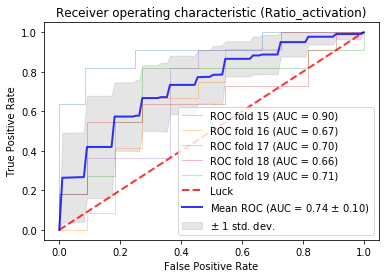

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}


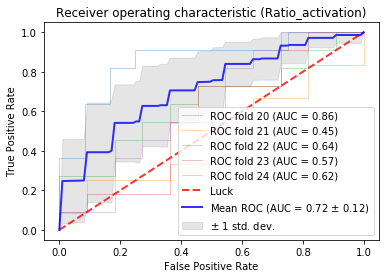

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}


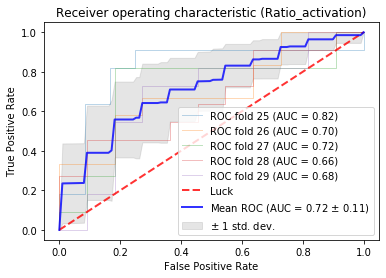

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}


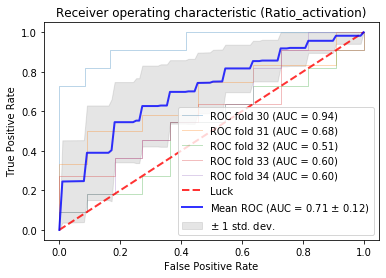

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 3}


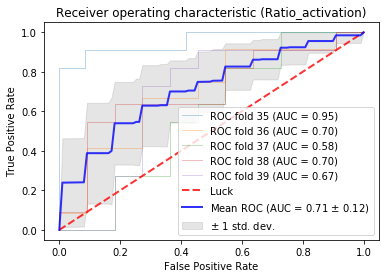

{'bootstrap': True, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 7}


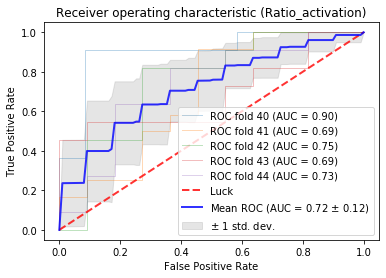

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}


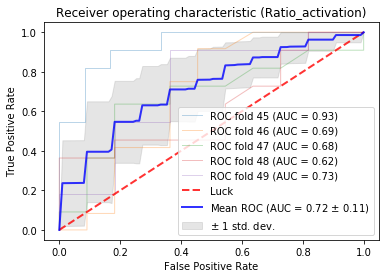

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 3}


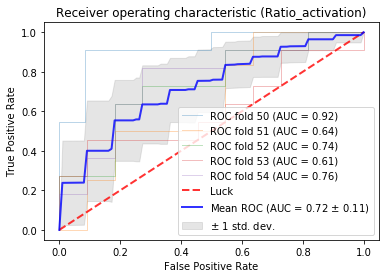

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 7}


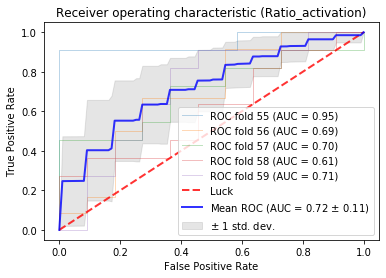

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}


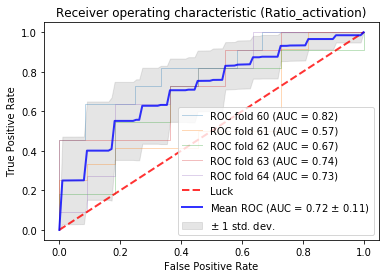

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}


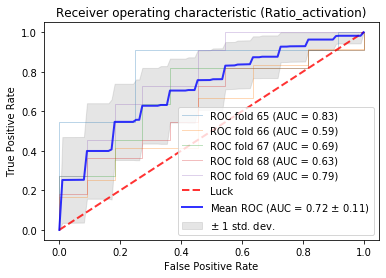

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 7}


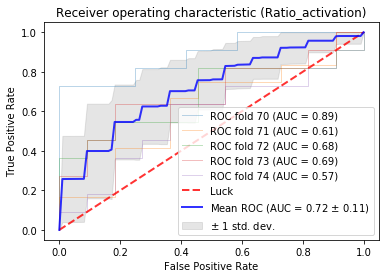

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}


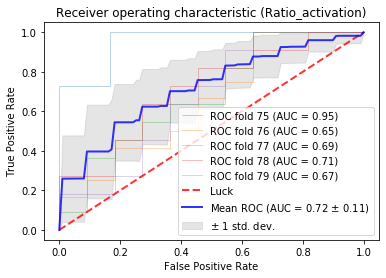

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 3}


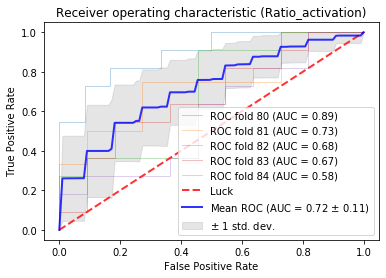

{'bootstrap': True, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 7}


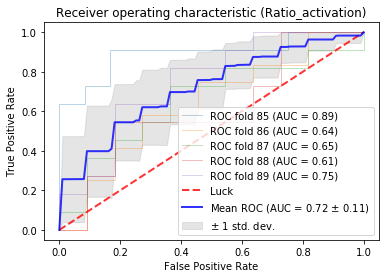

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}


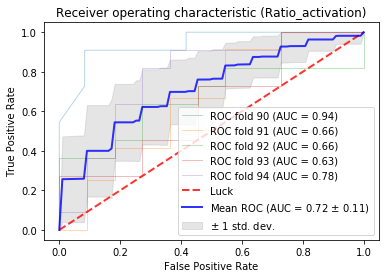

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 3}


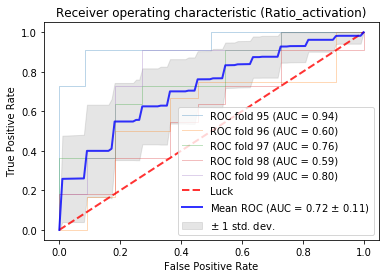

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 7}


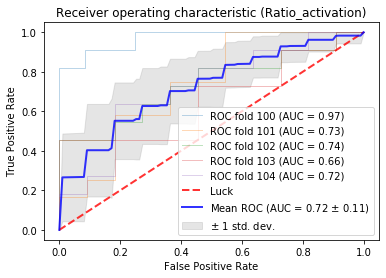

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 2}


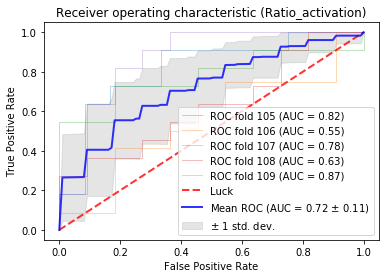

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 3}


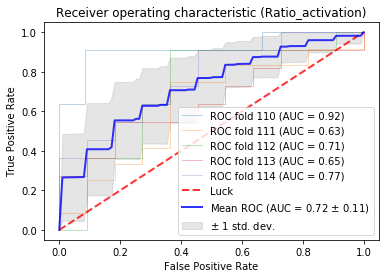

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 7}


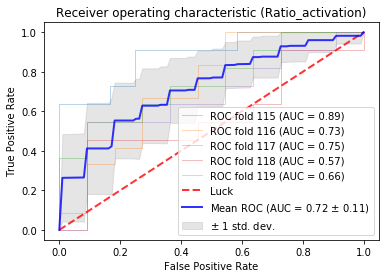

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 7, 'min_samples_split': 2}


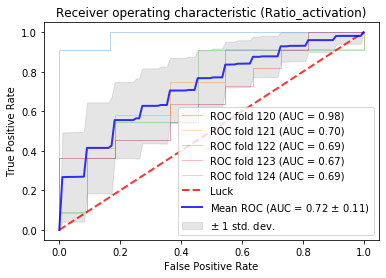

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 7, 'min_samples_split': 3}


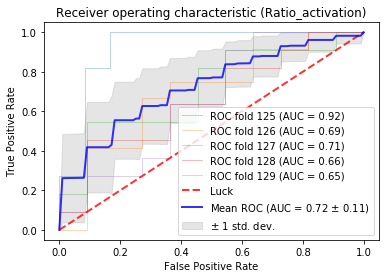

{'bootstrap': True, 'max_features': 11, 'min_samples_leaf': 7, 'min_samples_split': 7}


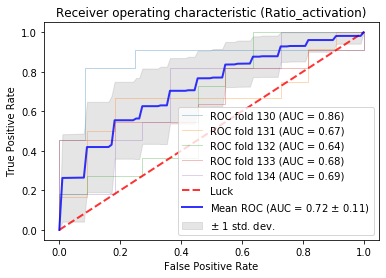

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 2}


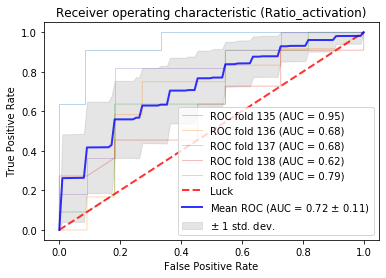

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 3}


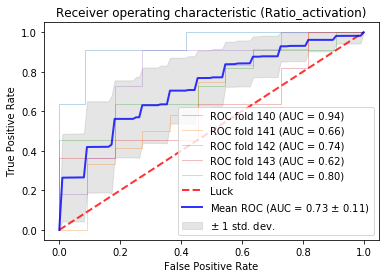

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 7}


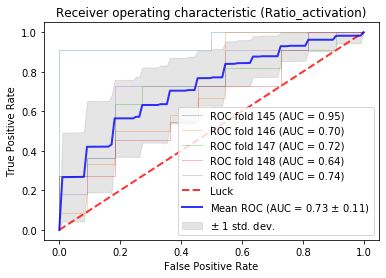

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 2}


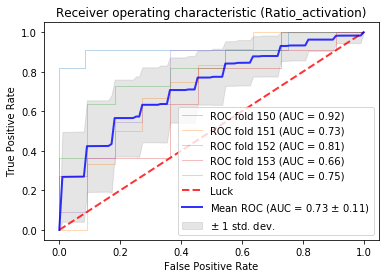

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 3}


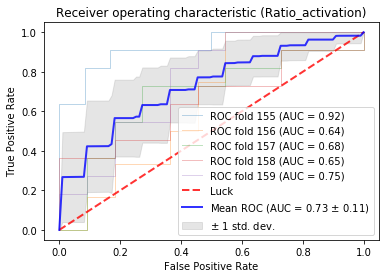

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 7}


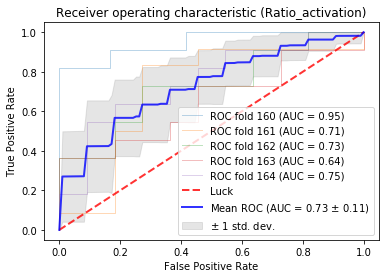

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 7, 'min_samples_split': 2}


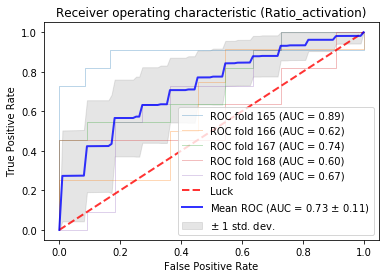

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 7, 'min_samples_split': 3}


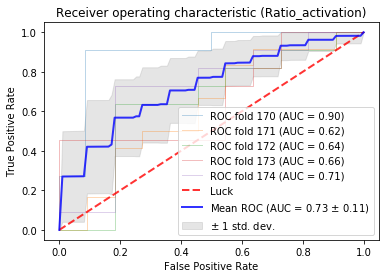

{'bootstrap': True, 'max_features': 19, 'min_samples_leaf': 7, 'min_samples_split': 7}


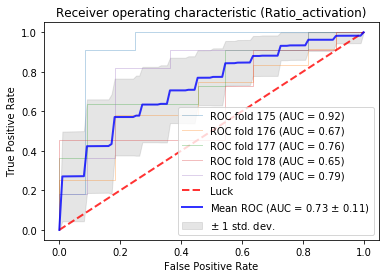

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}


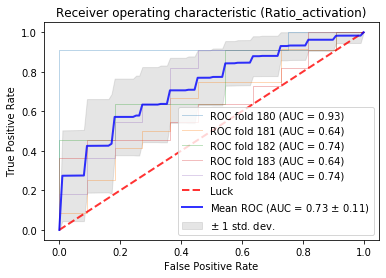

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 3}


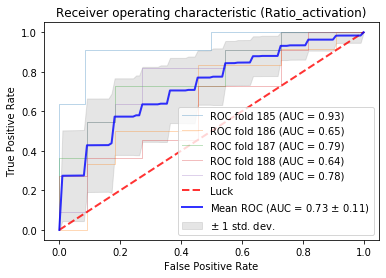

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 7}


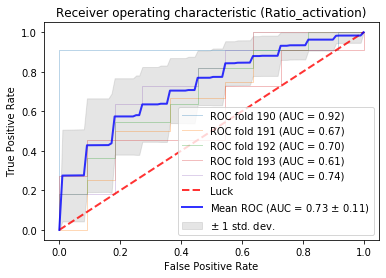

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 2}


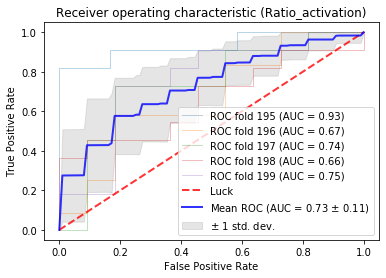

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 3}


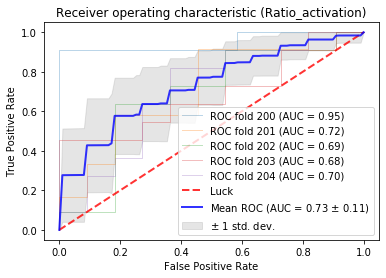

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 7}


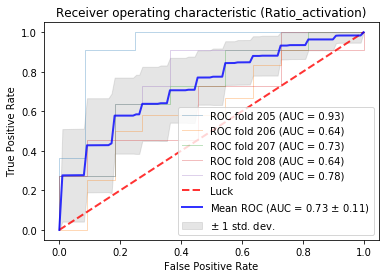

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 7, 'min_samples_split': 2}


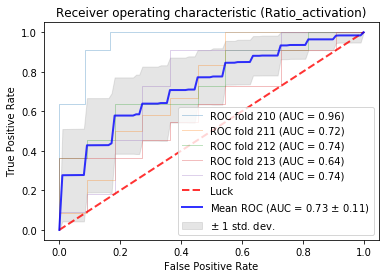

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 7, 'min_samples_split': 3}


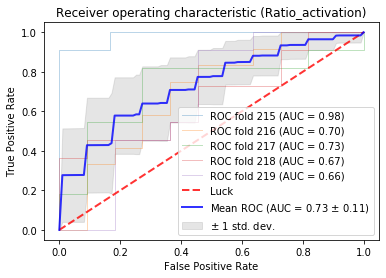

{'bootstrap': True, 'max_features': 32, 'min_samples_leaf': 7, 'min_samples_split': 7}


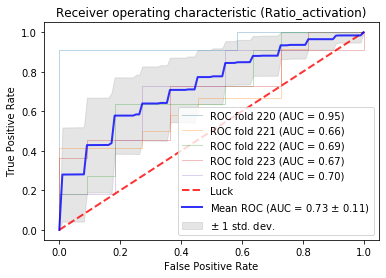

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 1, 'min_samples_split': 2}


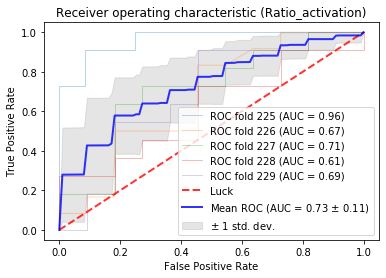

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 1, 'min_samples_split': 3}


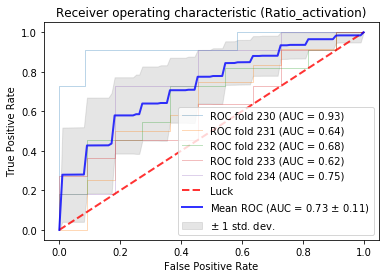

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 1, 'min_samples_split': 7}


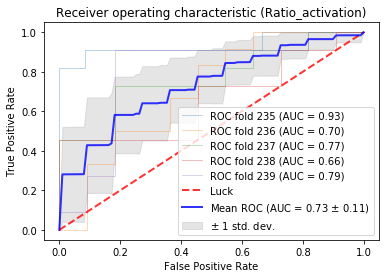

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 2}


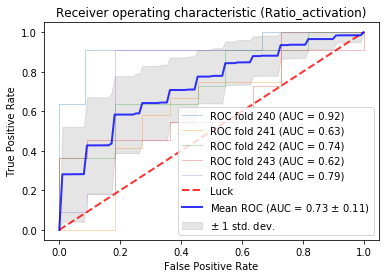

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 3}


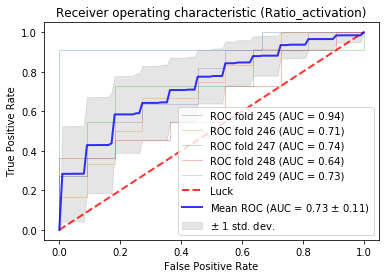

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 7}


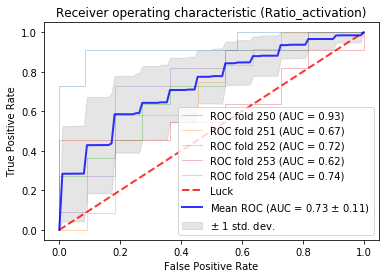

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 7, 'min_samples_split': 2}


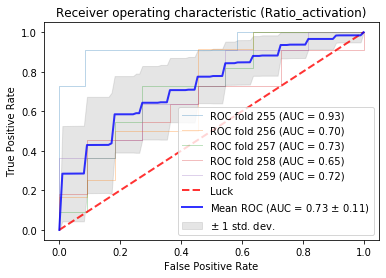

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 7, 'min_samples_split': 3}


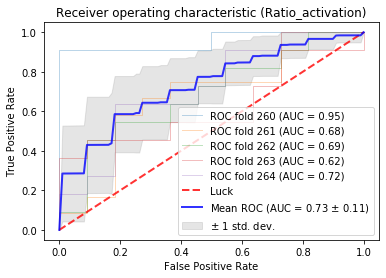

{'bootstrap': True, 'max_features': 53, 'min_samples_leaf': 7, 'min_samples_split': 7}


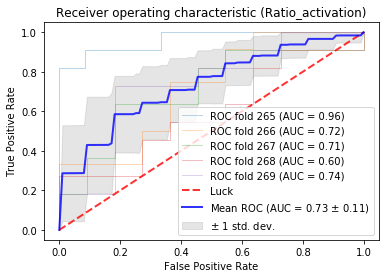

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 1, 'min_samples_split': 2}


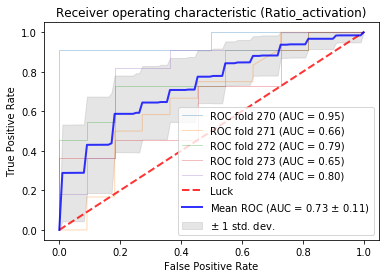

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 1, 'min_samples_split': 3}


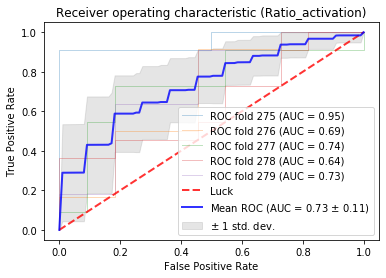

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 1, 'min_samples_split': 7}


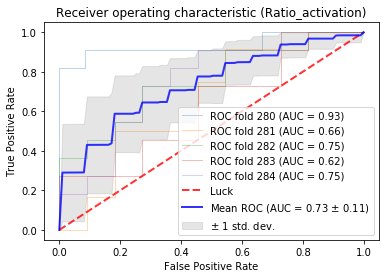

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 3, 'min_samples_split': 2}


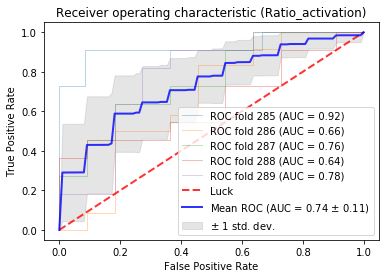

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 3, 'min_samples_split': 3}


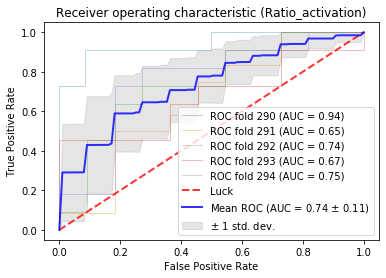

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 3, 'min_samples_split': 7}


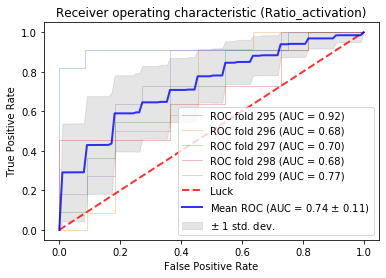

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 7, 'min_samples_split': 2}


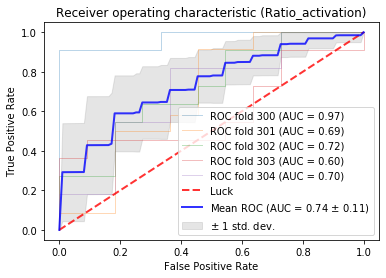

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 7, 'min_samples_split': 3}


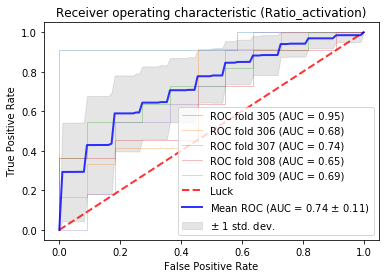

{'bootstrap': True, 'max_features': 90, 'min_samples_leaf': 7, 'min_samples_split': 7}


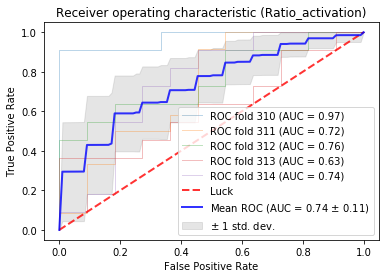

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 1, 'min_samples_split': 2}


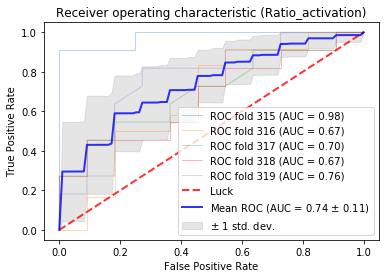

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 1, 'min_samples_split': 3}


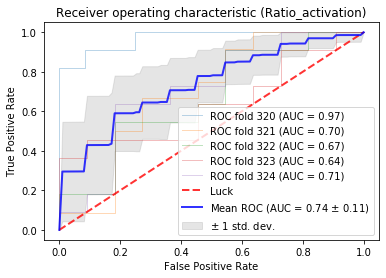

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 1, 'min_samples_split': 7}


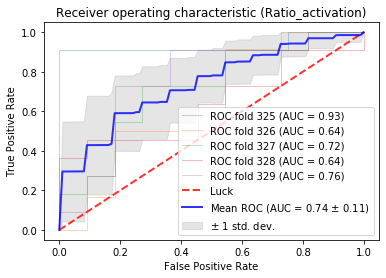

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 3, 'min_samples_split': 2}


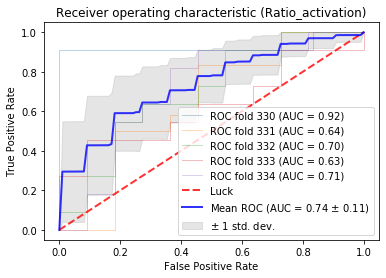

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 3, 'min_samples_split': 3}


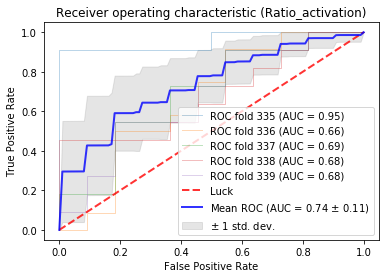

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 3, 'min_samples_split': 7}


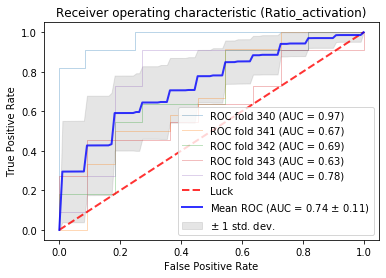

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 7, 'min_samples_split': 2}


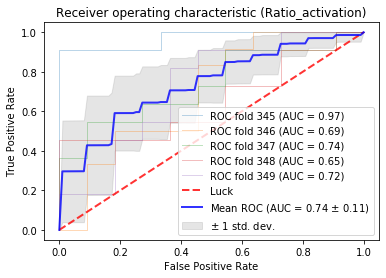

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 7, 'min_samples_split': 3}


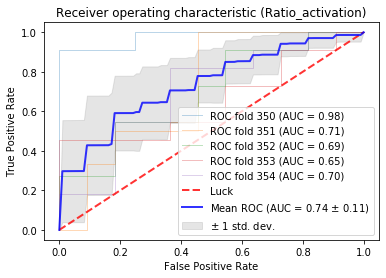

{'bootstrap': True, 'max_features': 152, 'min_samples_leaf': 7, 'min_samples_split': 7}


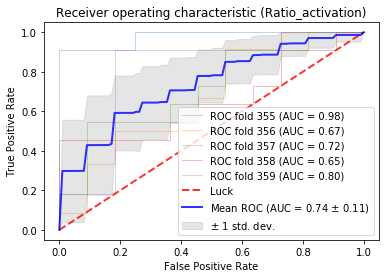

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 1, 'min_samples_split': 2}


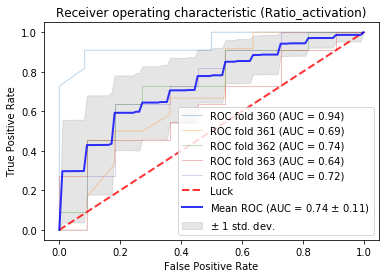

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 1, 'min_samples_split': 3}


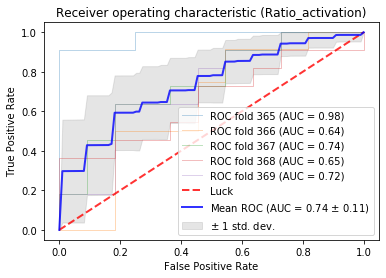

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 1, 'min_samples_split': 7}


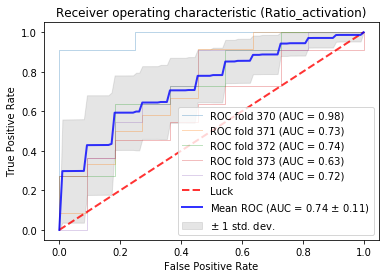

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 3, 'min_samples_split': 2}


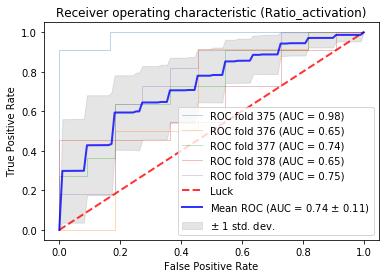

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 3, 'min_samples_split': 3}


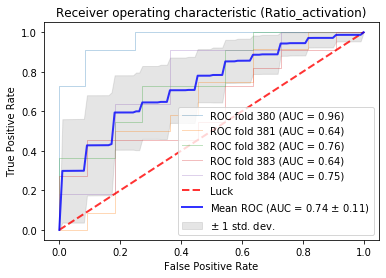

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 3, 'min_samples_split': 7}


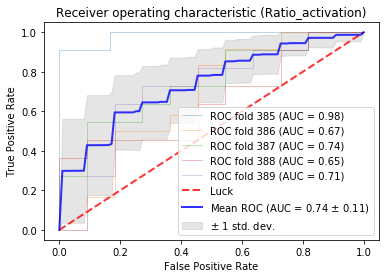

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 7, 'min_samples_split': 2}


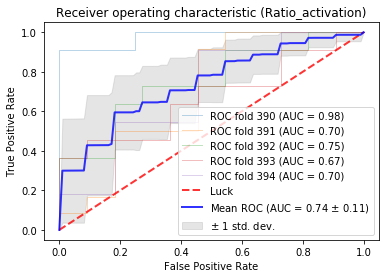

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 7, 'min_samples_split': 3}


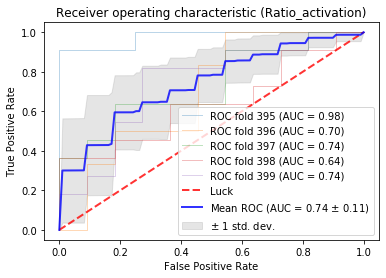

{'bootstrap': True, 'max_features': 256, 'min_samples_leaf': 7, 'min_samples_split': 7}


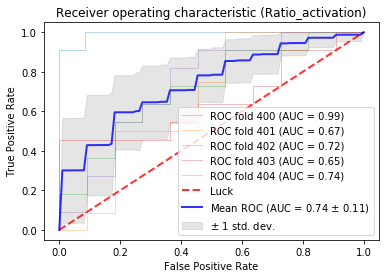

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


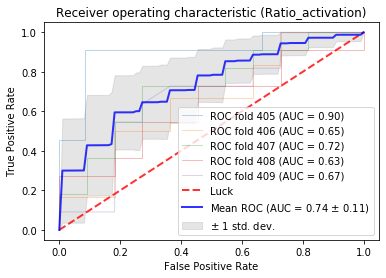

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}


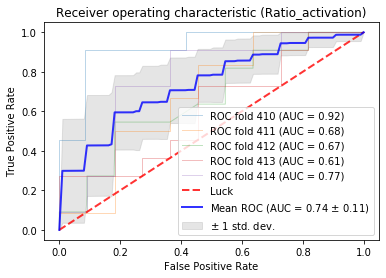

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 7}


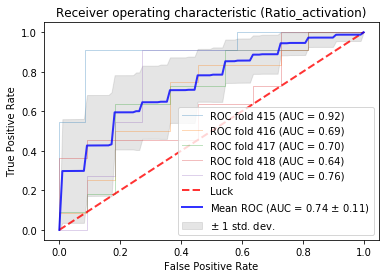

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


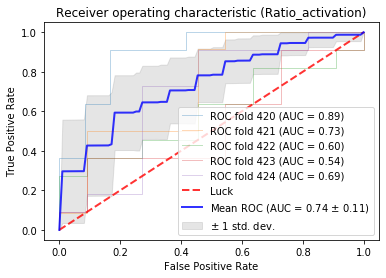

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 3}


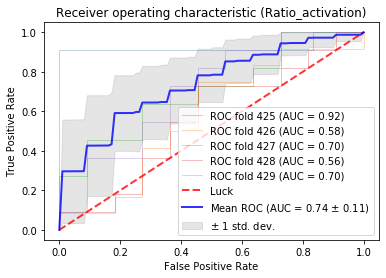

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}


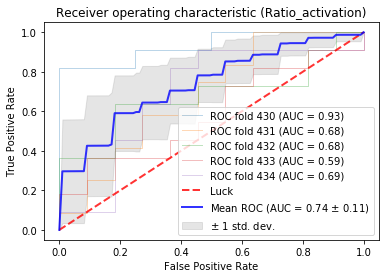

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}


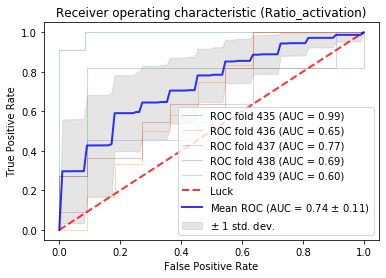

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 3}


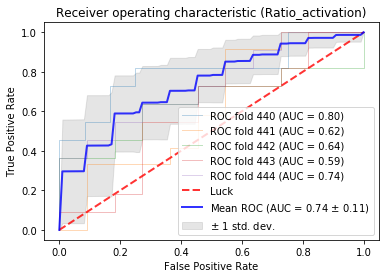

{'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 7, 'min_samples_split': 7}


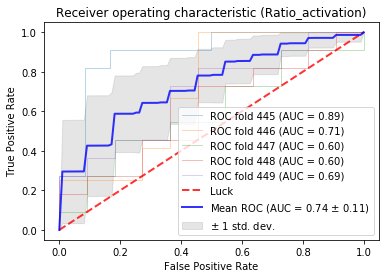

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}


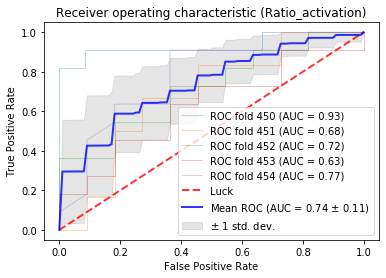

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 3}


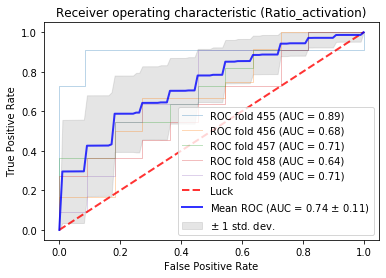

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 7}


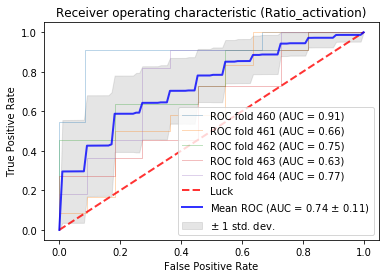

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}


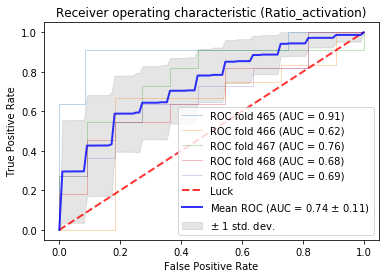

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}


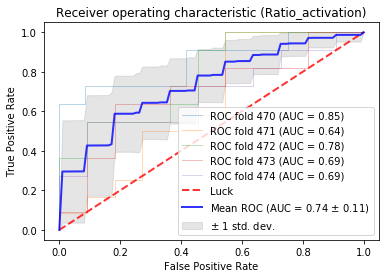

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 7}


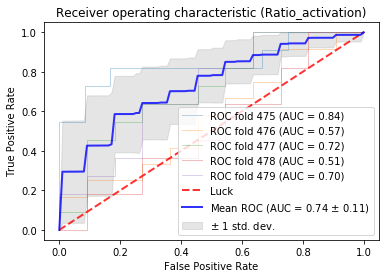

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}


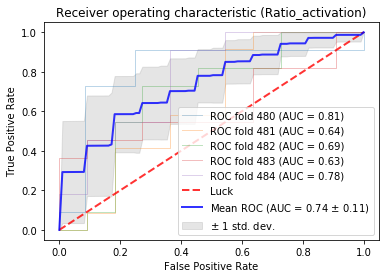

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 3}


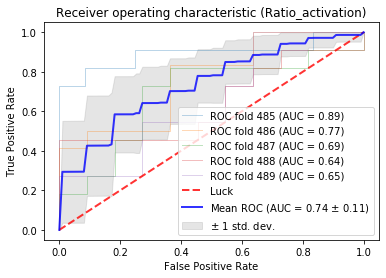

{'bootstrap': False, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 7}


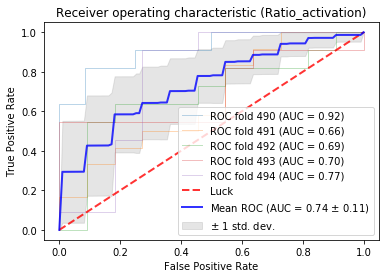

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}


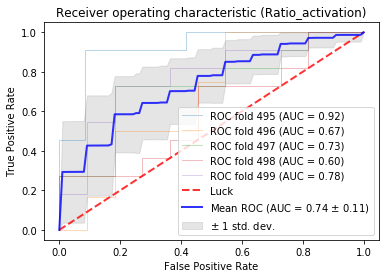

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 3}


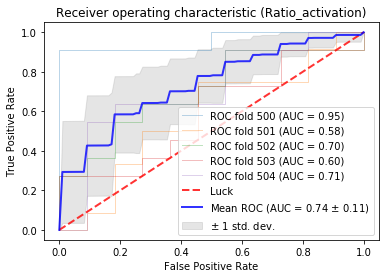

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 7}


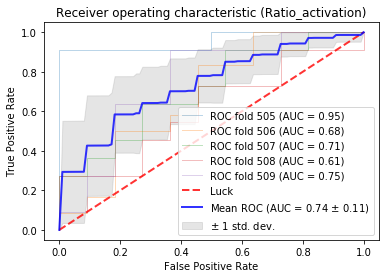

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 2}


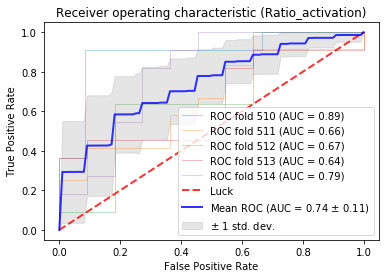

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 3}


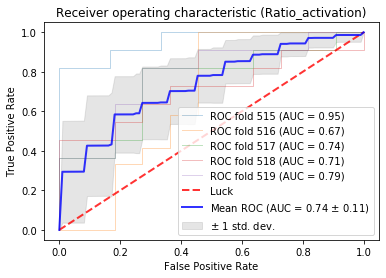

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 7}


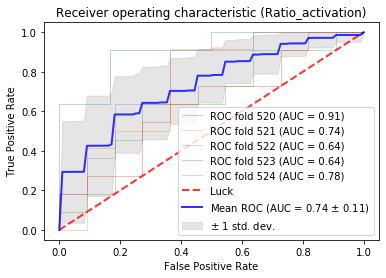

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 7, 'min_samples_split': 2}


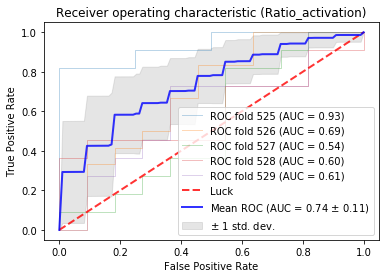

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 7, 'min_samples_split': 3}


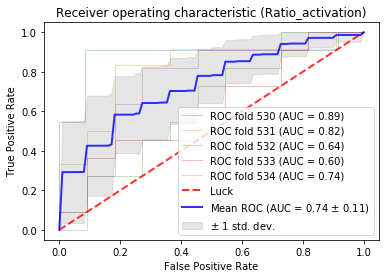

{'bootstrap': False, 'max_features': 11, 'min_samples_leaf': 7, 'min_samples_split': 7}


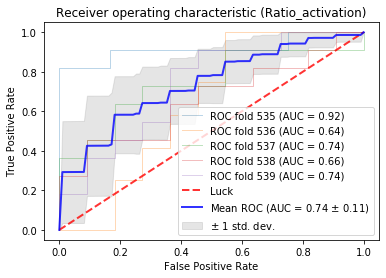

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 2}


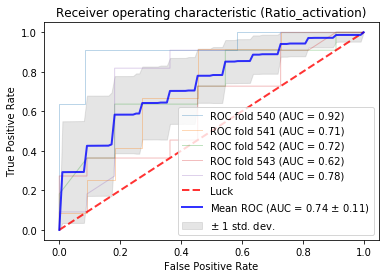

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 3}


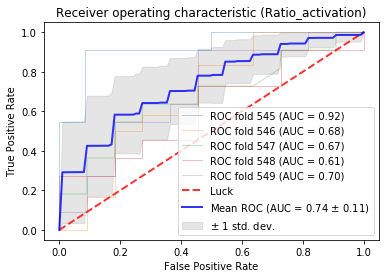

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 1, 'min_samples_split': 7}


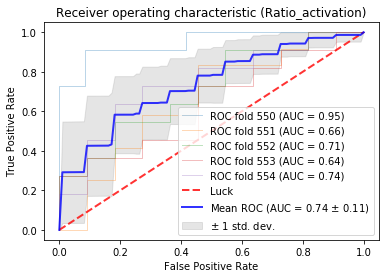

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 2}


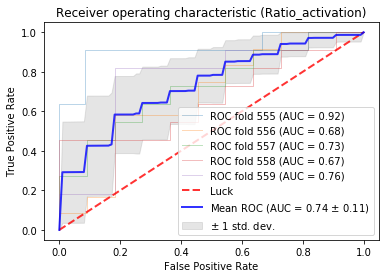

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 3}


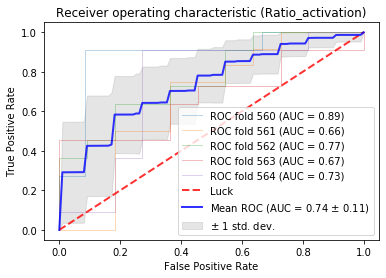

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 7}


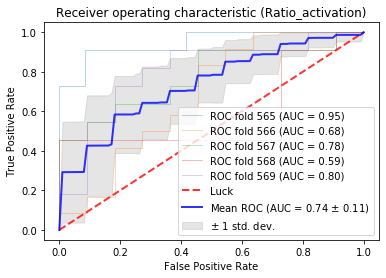

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 7, 'min_samples_split': 2}


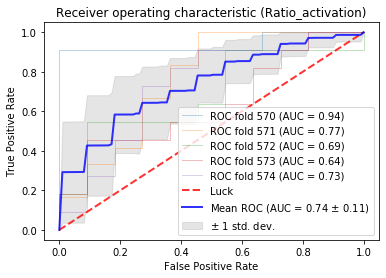

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 7, 'min_samples_split': 3}


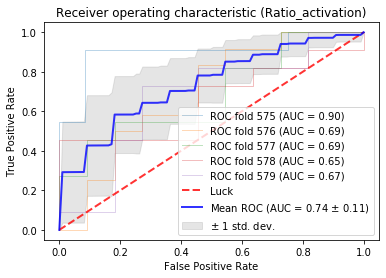

{'bootstrap': False, 'max_features': 19, 'min_samples_leaf': 7, 'min_samples_split': 7}


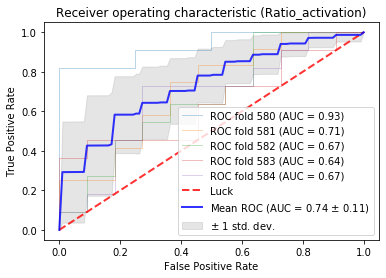

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}


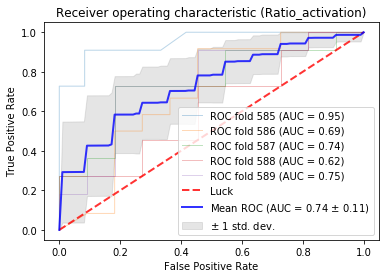

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 3}


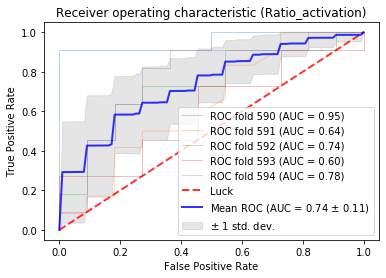

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 7}


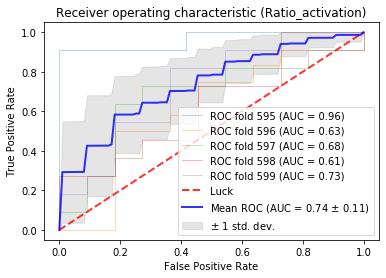

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 2}


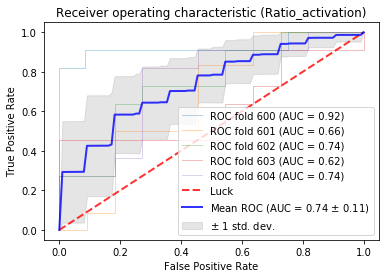

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 3}


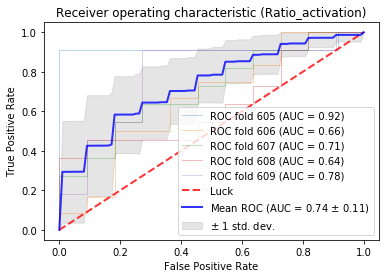

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 3, 'min_samples_split': 7}


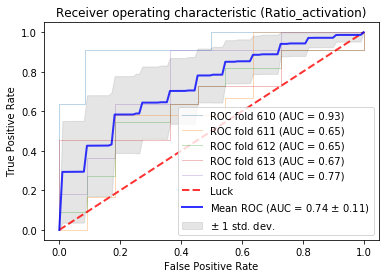

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 7, 'min_samples_split': 2}


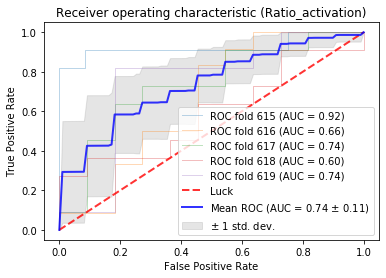

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 7, 'min_samples_split': 3}


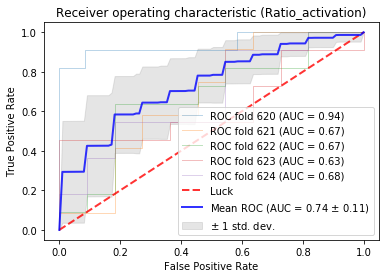

{'bootstrap': False, 'max_features': 32, 'min_samples_leaf': 7, 'min_samples_split': 7}


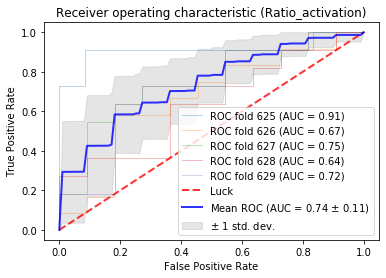

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 1, 'min_samples_split': 2}


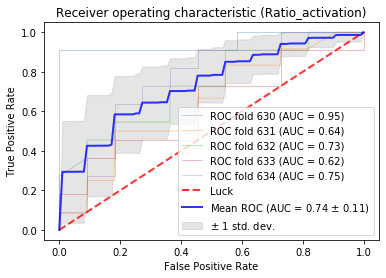

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 1, 'min_samples_split': 3}


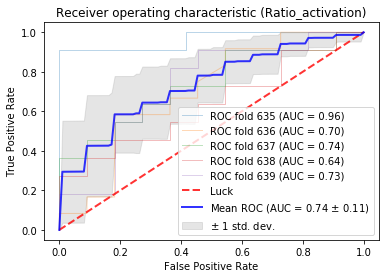

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 1, 'min_samples_split': 7}


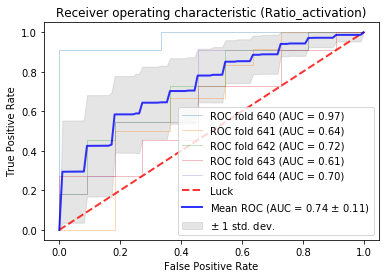

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 2}


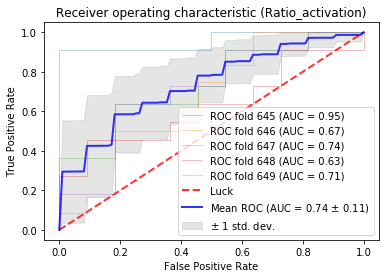

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 3}


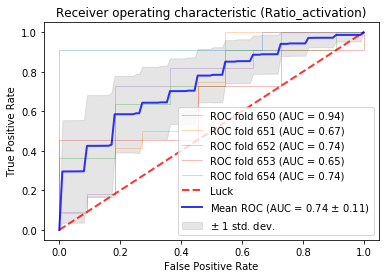

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 7}


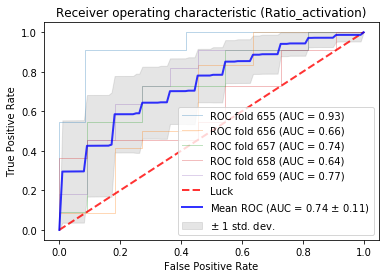

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 7, 'min_samples_split': 2}


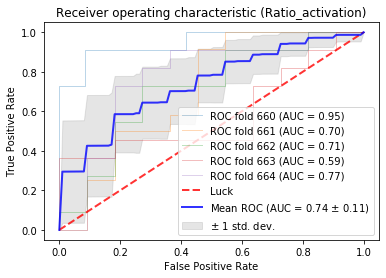

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 7, 'min_samples_split': 3}


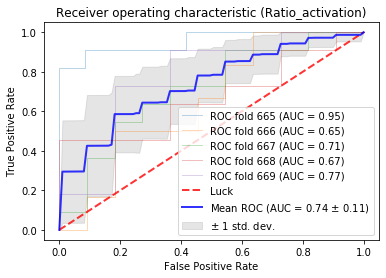

{'bootstrap': False, 'max_features': 53, 'min_samples_leaf': 7, 'min_samples_split': 7}


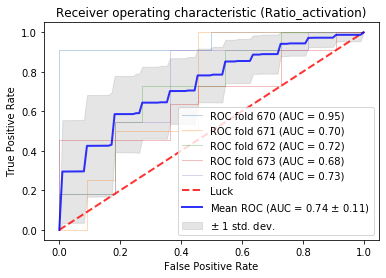

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 1, 'min_samples_split': 2}


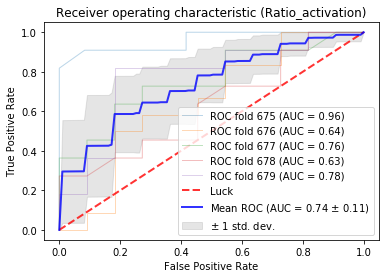

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 1, 'min_samples_split': 3}


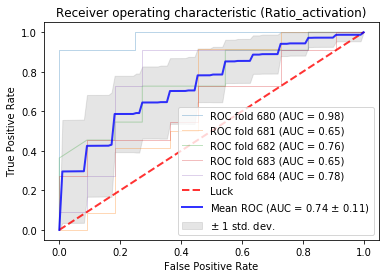

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 1, 'min_samples_split': 7}


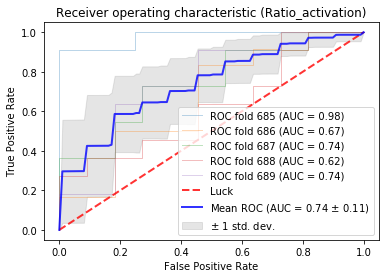

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 3, 'min_samples_split': 2}


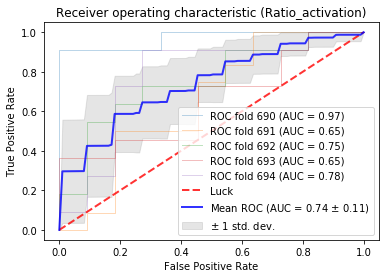

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 3, 'min_samples_split': 3}


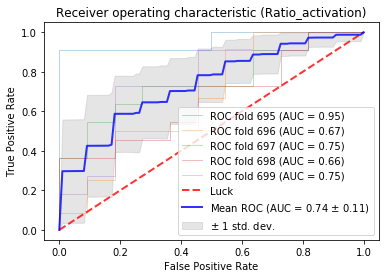

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 3, 'min_samples_split': 7}


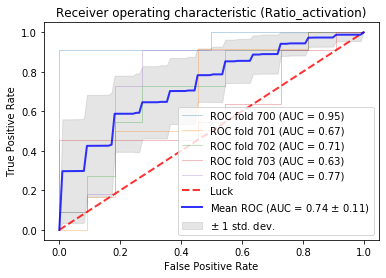

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 7, 'min_samples_split': 2}


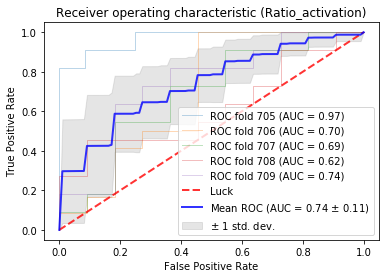

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 7, 'min_samples_split': 3}


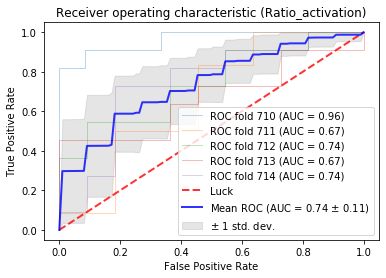

{'bootstrap': False, 'max_features': 90, 'min_samples_leaf': 7, 'min_samples_split': 7}


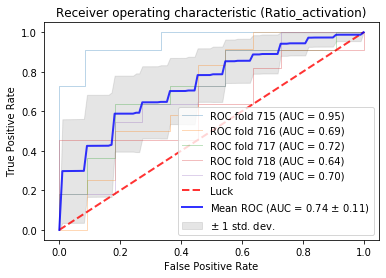

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 1, 'min_samples_split': 2}


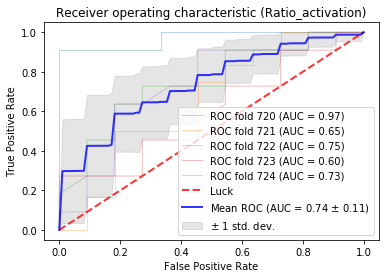

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 1, 'min_samples_split': 3}


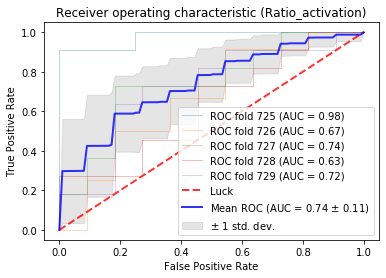

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 1, 'min_samples_split': 7}


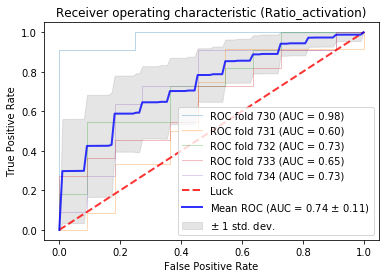

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 3, 'min_samples_split': 2}


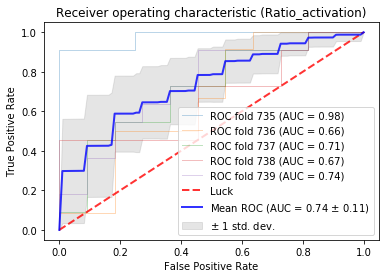

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 3, 'min_samples_split': 3}


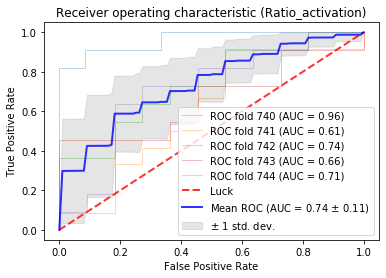

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 3, 'min_samples_split': 7}


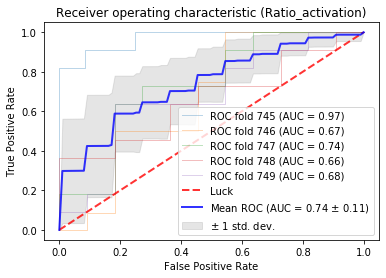

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 7, 'min_samples_split': 2}


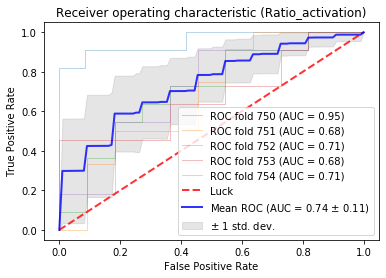

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 7, 'min_samples_split': 3}


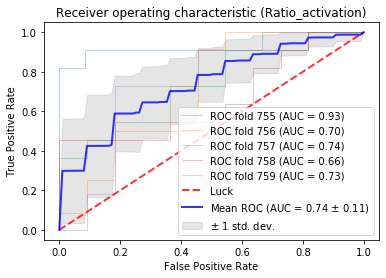

{'bootstrap': False, 'max_features': 152, 'min_samples_leaf': 7, 'min_samples_split': 7}


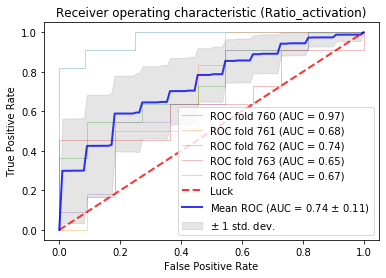

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 1, 'min_samples_split': 2}


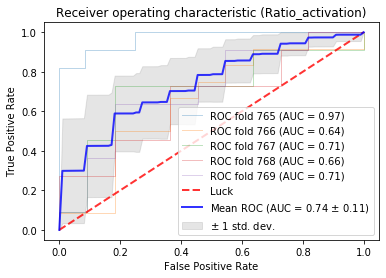

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 1, 'min_samples_split': 3}


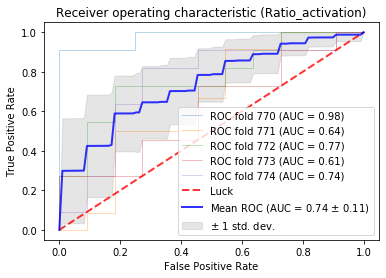

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 1, 'min_samples_split': 7}


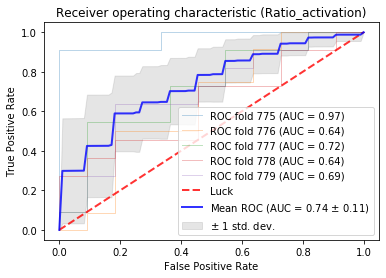

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 3, 'min_samples_split': 2}


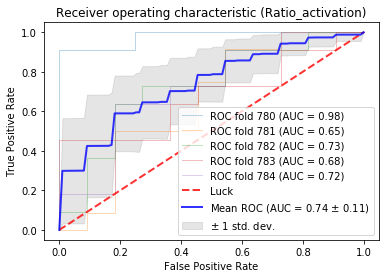

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 3, 'min_samples_split': 3}


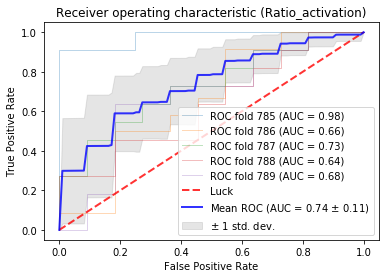

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 3, 'min_samples_split': 7}


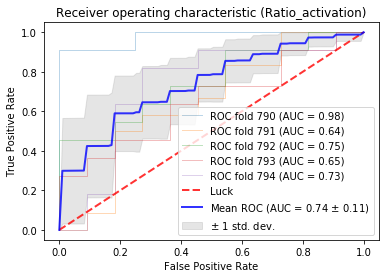

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 7, 'min_samples_split': 2}


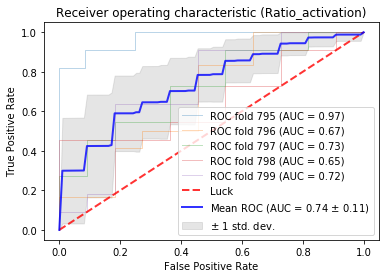

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 7, 'min_samples_split': 3}


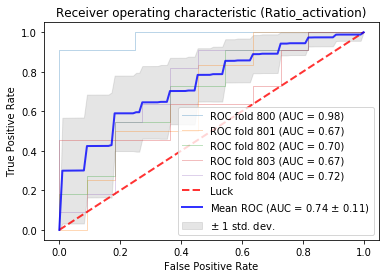

{'bootstrap': False, 'max_features': 256, 'min_samples_leaf': 7, 'min_samples_split': 7}


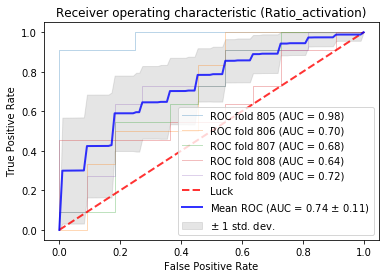

In [20]:
np.random.seed(31)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
cv = StratifiedKFold(n_splits=5)
i = 0
for params in ParameterGrid(param_grid):
    print(params)
    classifier = RandomForestClassifier(n_estimators=500, 
                                        bootstrap=params['bootstrap'], 
                                        max_features=params['max_features'],
                                        min_samples_leaf=params['min_samples_leaf'],
                                        min_samples_split=params['min_samples_split'])
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (Ratio_activation)')
    plt.legend(loc='lower right')
    plt.show()

In [21]:
rf_optimal = RandomForestClassifier(n_estimators=500, bootstrap=True, max_features=4,
                                    min_samples_leaf=3, min_samples_split=2)
rf_optimal.fit(X, y) # mac AUC: 0.74 (sd 0.10)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
# highly discriminative
sum(rf_optimal.feature_importances_ >= 0.01)

13

In [23]:
# moderately discriminative
sum(rf_optimal.feature_importances_ >= 0.002)

133

In [24]:
rf_optimal.feature_importances_[rf_optimal.feature_importances_ >=0.002]
idx = np.where(rf_optimal.feature_importances_ >=0.002)
idx

(array([   0,   19,   25,   43,   44,   64,   72,   73,   91,   96,  102,
         108,  117,  127,  136,  142,  154,  174,  180,  193,  200,  214,
         216,  218,  221,  226,  234,  254,  255,  257,  259,  296,  298,
         300,  304,  343,  354,  378,  396,  397,  399,  400,  410,  412,
         440,  449,  450,  458,  464,  474,  475,  478,  484,  487,  541,
         565,  592,  593,  599,  614,  637,  638,  648,  654,  666,  677,
         733,  755,  782,  785,  789,  792,  799,  803,  805,  817,  825,
         852,  859,  920,  922,  930,  933,  974,  984,  992, 1004, 1038,
        1073, 1078, 1079, 1122, 1177, 1205, 1263, 1303, 1350, 1353, 1398,
        1466, 1516, 1595, 1637, 1639, 1640, 1728, 1740, 1749, 1862, 1904,
        1910, 2075, 2195, 2212, 2370, 2413, 2552, 2642, 2719, 2766, 2909,
        3032, 3062, 3420, 3431, 3685, 4442, 5161, 5812, 6791, 6822, 7246,
        7728]),)

In [25]:
A = table.loc[Y.index]
A.head()

#OTU ID    TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG  \
#SampleID                                                                                                                                                           
BI0371                                                   1.0                                                                                                        
BI0404                                                 111.0                                                                                                        
BI0411                                                 240.0                                                                                                        
BI0426                                                   0.0                                                                                                        
BI0428                                                  19.0                                                                                                        

#OTU ID    TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAACATCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG  \
#SampleID                                                                                                                                                           
BI0371                                                   0.0                                                                                                        
BI0404                                                 184.0                                                                                                        
BI0411                                                   0.0                                                                                                        
BI0426                                                   0.0                                                                                                        
BI0428                                                   0.0                                                                                                        

#OTU ID    TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGCGGCGTAAGTCAGTTGTGAAATCGTGCGGCTTAACCGTGCAATTGCAGTTGATACTGCGTCGCTTGAGTGCACACAGGGATGTTGGAATTCATGG  \
#SampleID                                                                                                                                                           
BI0371                                                   0.0                                                                                                        
BI0404                                                 127.0                                                                                                        
BI0411                                                   0.0                                                                                                        
BI0426                                                   0.0                                                                                                        
BI0428                                                   0.0                                                                                                        

#OTU ID    TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGAGGCTCAACCTCTGCACTGCAGCGCGAACTGGTCTTCTTGAGTACGCACAACGTGGGCGGAATTCGTGG  \
#SampleID                                                                                                                                                           
BI0371                                                   0.0                                                                                                        
BI0404                               

In [26]:
OTUs = A[A.columns[idx]].columns
OTUs

Index(['TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGG',
       'TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGATCGCAAGTCAGATGTGAAAACTATGGGCTTAACCCATAAACTGCATTTGAAACTGTGGTTCTTGAGTGAAGTAGAGGTAAGCGGAATTCCTAG',
       'TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCTTAAGTCCATCTTAAAAGTGCGGGGCTTAACCCCGTGATGGGATGGAAACTGGGAGGCTGGAGTATCGGAGAGGAAAGTGGAATTCCTAGT',
       'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGGAGACAAGTCAGATGTGAAATCTGGAGGCTCAACCTCCAAACTGCATTTGAAACTGTTTCTCTTGAGTATCGGAGAGGTAATCGGAATTCCTAG',
       'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAG',
       'TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTGATAAGTCTGAAGTTAAAGGCTGTGGCTCAACCATAGTTCGCTTTGGAAACTGTCAAACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGT',
       'TACGTAGGGAGCAAGCGTTGTCCGGA

In [27]:
taxa.head(3)

Taxon  \
Feature ID                                                                                              
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   

                                                    Confidence  
Feature ID                                                      
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...         1.0  
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...         1.0  
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...         1.0

In [28]:
B = taxa.loc[OTUs]
B.head()

Taxon  \
#OTU ID                                                                                                 
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGT...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...  k__Bacteria; p__Firmicutes; c__Clostridia; o__...   

                                                    Confidence  
#OTU ID                                                         
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGC...    1.000000  
TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGC...    0.850788  
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGC...    0.999998  
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGT...    0.995495  
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGC...    0.999990

In [29]:
B['importance'] = rf_optimal.feature_importances_[idx]

In [30]:
B.shape

(133, 3)

In [31]:
B.to_csv('../data/RF_taxa_act.txt', sep='\t')

In [32]:
B.Taxon.nunique()

50

In [33]:
B.Taxon.value_counts()

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__; s__                                       15
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__                                       12
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__                           11
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__                                                      11
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Oscillospira; s__                           10
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae                                                  6
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia; s__                                 6
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g_